In [1]:
# Try to understand Zackay+Ofek paper II

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
from matplotlib.patches import Polygon
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import *
from astrometry.util.util import Tan
from astrometry.util.plotutils import *
from astrometry.libkd.spherematch import match_radec
from collections import Counter
from astrometry.util.starutil import *
from scipy.ndimage.filters import *
from scipy.ndimage.measurements import label, find_objects
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

In [329]:
H,W = 64,64 #256,256
psf_s1 = 2.
psf_s2 = 4.
F1 = 1.
F2 = 1.
sig_1 = 1.
sig_2 = 1.
xx,yy = np.meshgrid(np.arange(W), np.arange(H))
cx,cy = W//2, H//2
cx1 = cx
cx2 = cx
img1 = np.exp(-0.5 * ((xx-cx1)**2 + (yy-cy)**2)/psf_s1**2)
img1 /= np.sum(img1)
img2 = np.exp(-0.5 * ((xx-cx2)**2 + (yy-cy)**2)/psf_s2**2)
img2 /= np.sum(img2)

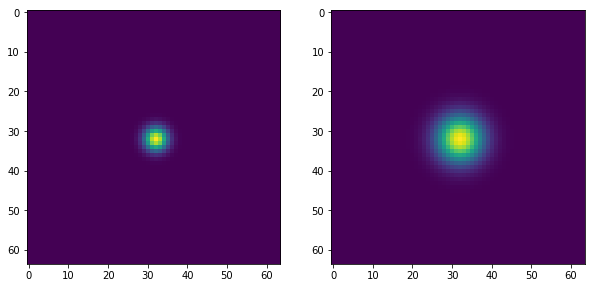

In [330]:
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2);

In [331]:
psf1 = img1
psf2 = img2

In [332]:
P1 = np.fft.rfft2(psf1)
P1.dtype
print(P1.real.min(), P1.real.max())
print(P1.imag.min(), P1.imag.max())
P2 = np.fft.rfft2(psf2)
P2.dtype
print(P2.real.min(), P2.real.max())
print(P2.imag.min(), P2.imag.max())

-0.9809080339138543 1.0
-2.205423072897811e-15 1.946481712790382e-15
-0.9257914512036213 1.0
-2.118856305688421e-15 1.968911145233676e-15


In [333]:
# Image FFTs = PSF FFTs
M1 = P1
M2 = P2

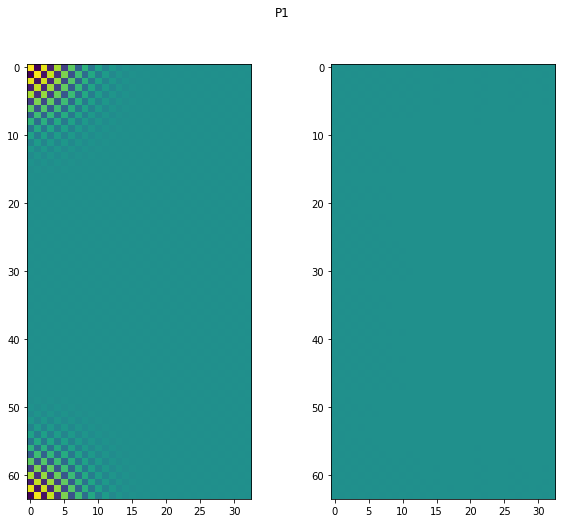

In [334]:
plt.subplot(1,2,1)
plt.imshow(P1.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P1.imag, vmin=-1, vmax=1)
plt.suptitle('P1');

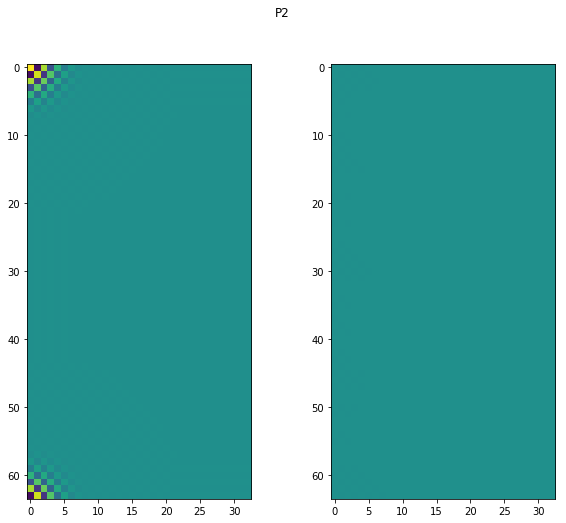

In [335]:
plt.subplot(1,2,1)
plt.imshow(P2.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P2.imag, vmin=-1, vmax=1)
plt.suptitle('P2');

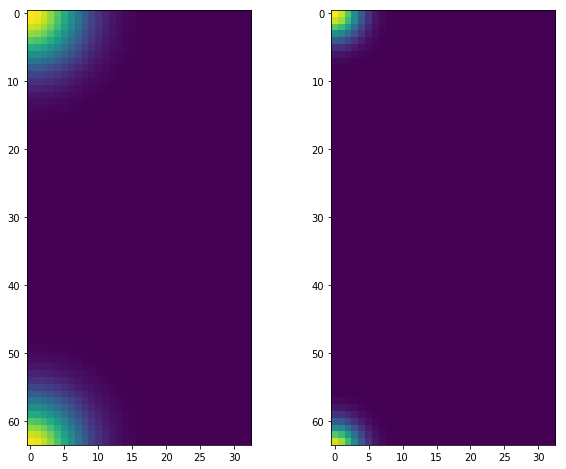

In [336]:
plt.subplot(1,2,1)
plt.imshow(np.abs(P1), vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(np.abs(P2), vmin=0, vmax=1);

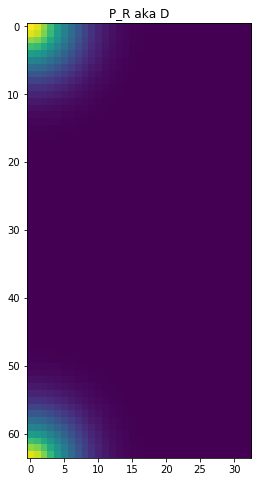

In [367]:
D = np.sqrt((F1**2 / sig_1**2) * np.abs(P1)**2 + (F2**2 / sig_2**2) * np.abs(P2)**2)
plt.imshow(D)
plt.title('P_R aka D');

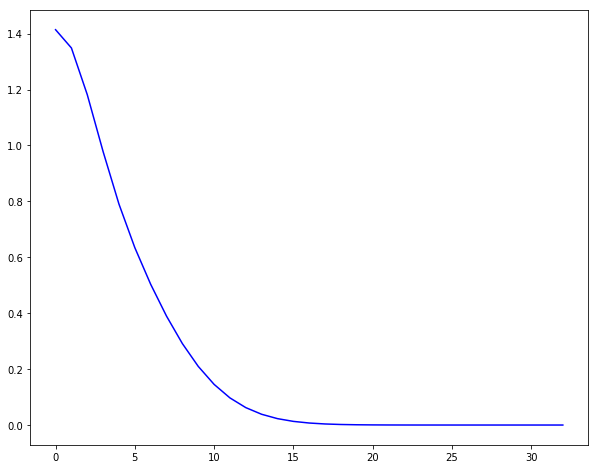

In [368]:
plt.plot(D[0,:], 'b-');

In [369]:
N = (F1 / sig_1**2) * (P1 * M1) + (F2 / sig_2**2) * (P2 * M2)

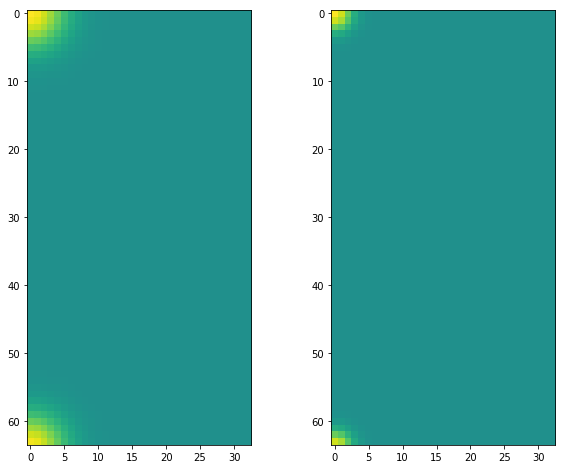

In [370]:
plt.subplot(1,2,1)
plt.imshow((P1 * M1).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((P2 * M2).real, vmin=-1, vmax=1);

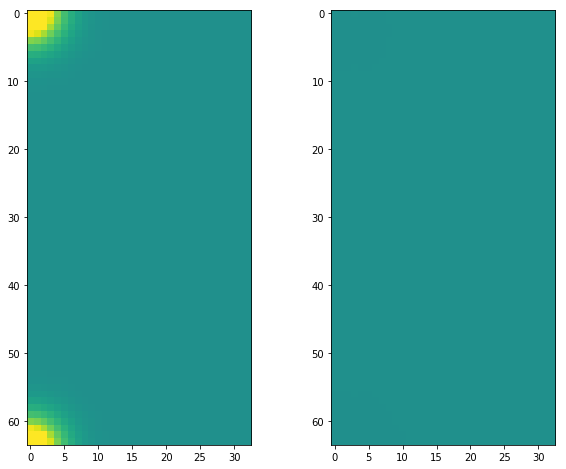

In [371]:
plt.subplot(1,2,1)
plt.imshow(N.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(N.imag, vmin=-1, vmax=1);

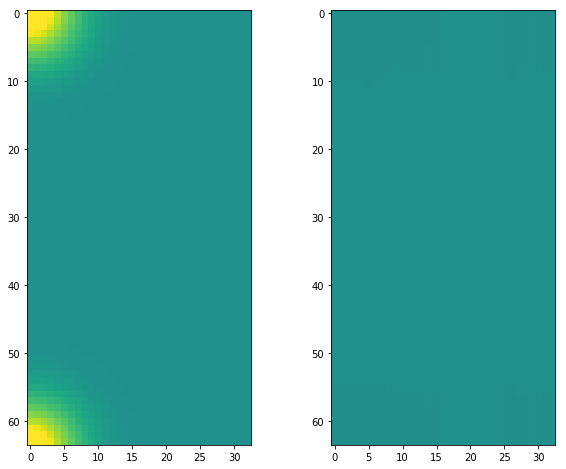

In [372]:
plt.subplot(1,2,1)
plt.imshow((N/D).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((N/D).imag, vmin=-1, vmax=1);

In [373]:
R = N/D
R.dtype, R.shape

(dtype('complex128'), (64, 33))

In [374]:
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)
print(imgR.dtype, imgR.shape)
Counter(np.sign(imgR).ravel())

float64 (64, 64)


Counter({1.0: 2484, -1.0: 1612})

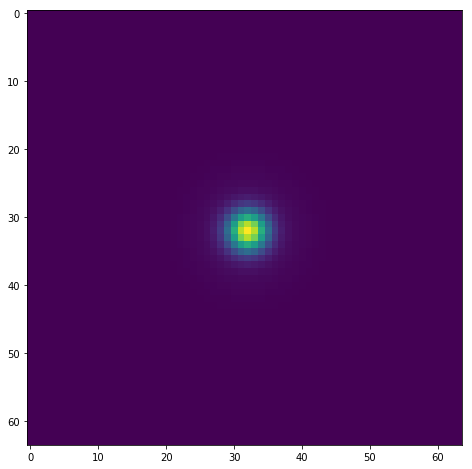

In [392]:
plt.imshow(imgR);

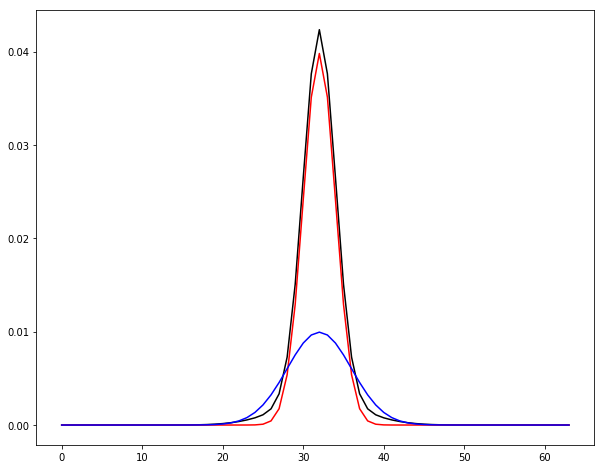

In [393]:
plt.plot(imgR[cy,:], color='k')
plt.plot(img1[cy,:], color='r')
plt.plot(img2[cy,:], color='b');

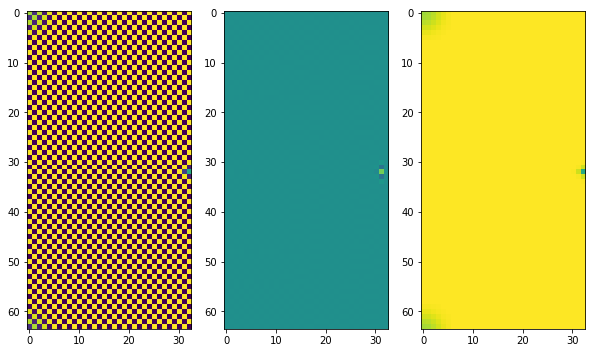

In [394]:
plt.subplot(1,3,1)
plt.imshow((P1 / D).real, vmin=-1, vmax=1)
plt.subplot(1,3,2)
plt.imshow((P1 / D).imag, vmin=-1, vmax=1)
plt.subplot(1,3,3)
plt.imshow(np.abs(P1 / D), vmin=-1, vmax=1);

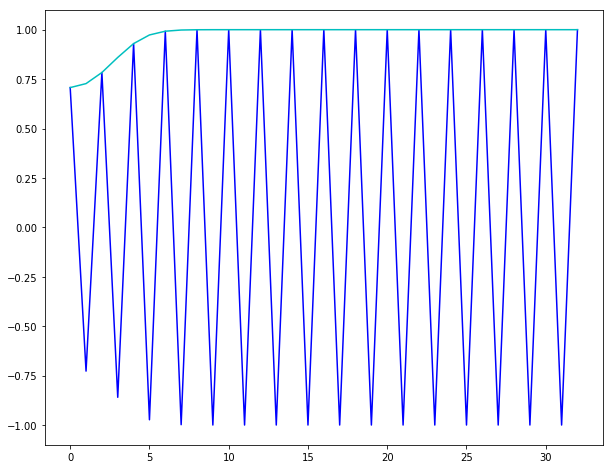

In [382]:
plt.plot((P1/D).real[0,:], 'b-')
plt.plot(np.abs(P1/D)[0,:], 'c-');

In [383]:
# ic1 is the effective convolution kernel to go from img1 to R
ic1 = np.fft.irfft2(P1/D)
ic1.dtype, ic1.shape

(dtype('float64'), (64, 64))

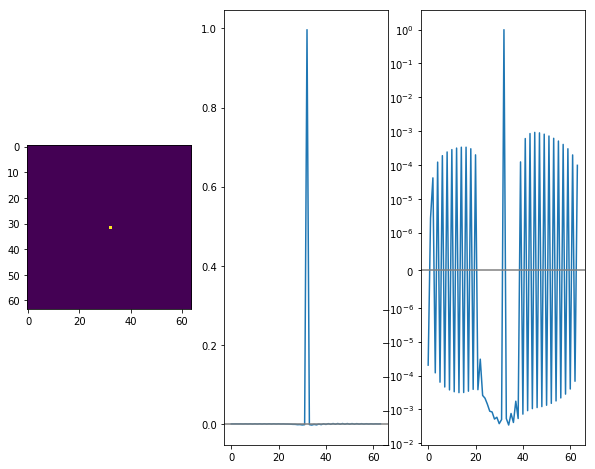

In [386]:
plt.subplot(1,3,1)
plt.imshow(ic1) #, cmap='RdBu', vmin=-0.05, vmax=0.05)
#plt.axis([cx-15,cx+15,cy-15,cy+15])
plt.subplot(1,3,2)
plt.plot(ic1[cy,:])
plt.axhline(0, color='0.5');
plt.subplot(1,3,3)
plt.plot(ic1[cy,:])
plt.yscale('symlog', linthreshy=1e-6);
plt.axhline(0, color='0.5');

In [387]:
ic1.sum(), psf1.sum()

(0.7071067811865475, 1.0)

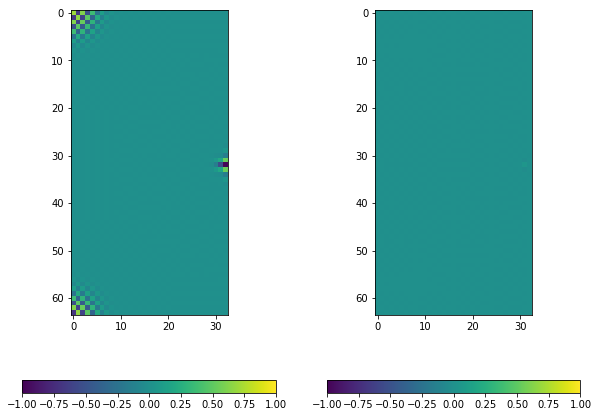

In [395]:
plt.subplot(1,2,1)
plt.imshow((P2 / D).real, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow((P2 / D).imag, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal');

In [396]:
ic2 = np.fft.irfft2(P2/D)
ic2.dtype, ic2.shape

(dtype('float64'), (64, 64))

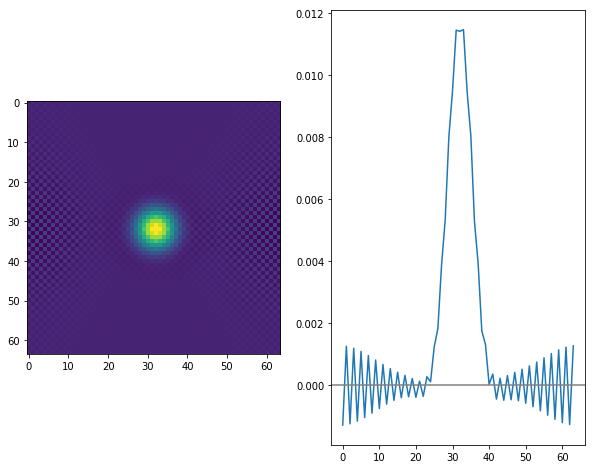

In [397]:
# this is the effective convolution filter to go from img2 to R.
plt.subplot(1,2,1)
plt.imshow(ic2)
plt.subplot(1,2,2)
plt.plot(ic2[cy,:]);
plt.axhline(0, color='0.5');

In [357]:
ic2[cy,:].min(), ic2[cy,:].max()
ic2.sum(), np.sqrt(np.sum(ic2**2))

(0.7071067811865476, 0.05837687378461367)

In [398]:
imgPR = np.fft.ifftshift(np.fft.irfft2(D))
imgPR.dtype, imgPR.shape

(dtype('float64'), (64, 64))

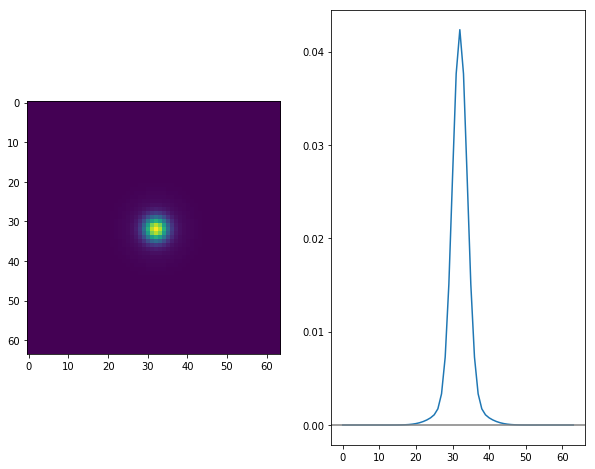

In [399]:
# This is the PSF of image R.
plt.subplot(1,2,1)
plt.imshow(imgPR)
plt.subplot(1,2,2)
plt.plot(imgPR[cy,:]);
plt.axhline(0, color='0.5');

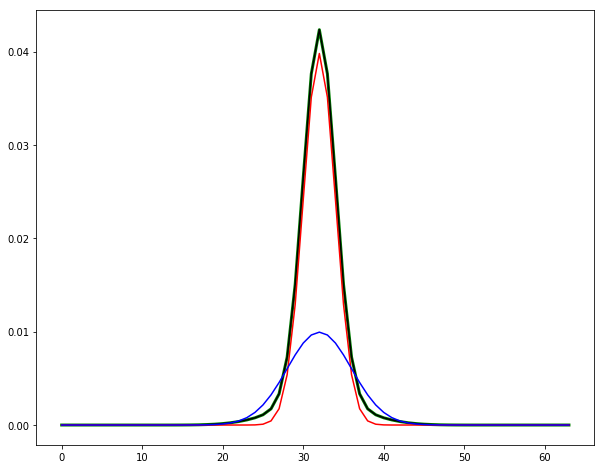

In [402]:
plt.plot(imgPR[cy,:], 'g', lw=3);
plt.plot(imgR[cy,:], color='k')
plt.plot(img1[cy,:], color='r')
plt.plot(img2[cy,:], color='b');

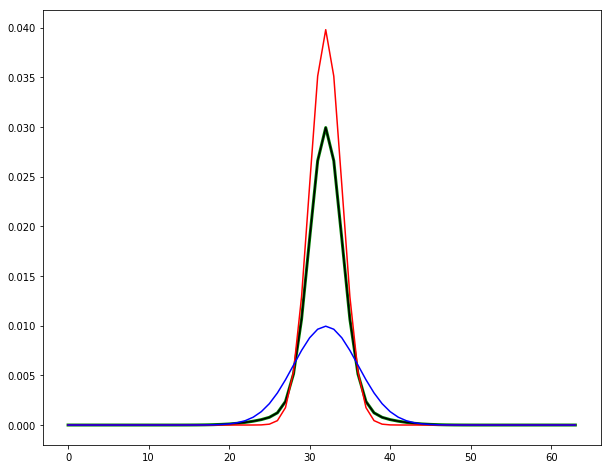

In [403]:
plt.plot(imgPR[cy,:] / np.sum(imgPR), 'g', lw=3);
plt.plot(imgR[cy,:] / np.sum(imgR), color='k')
plt.plot(img1[cy,:] / np.sum(img1), color='r')
plt.plot(img2[cy,:] / np.sum(img2), color='b');

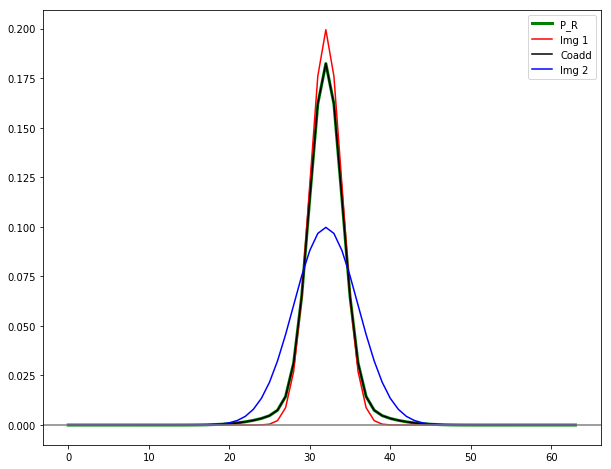

In [404]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', lw=3, label='P_R');
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Img 1')
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='Coadd')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Img 2')
plt.legend()
plt.axhline(0, color='0.5');

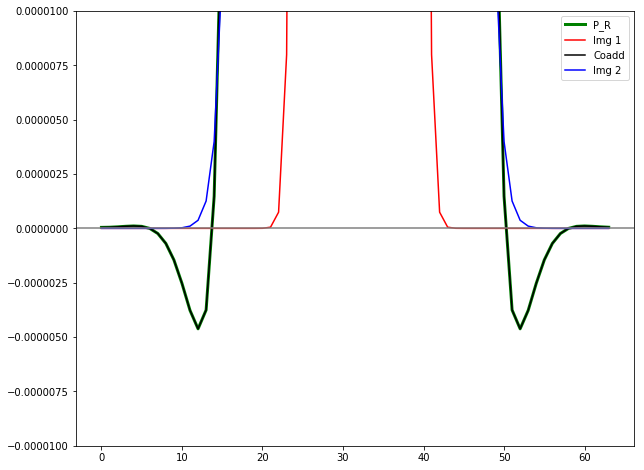

In [409]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', lw=3, label='P_R');
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Img 1')
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='Coadd')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Img 2')
plt.legend()
plt.axhline(0, color='0.5');
plt.ylim(-1e-5, 1e-5);

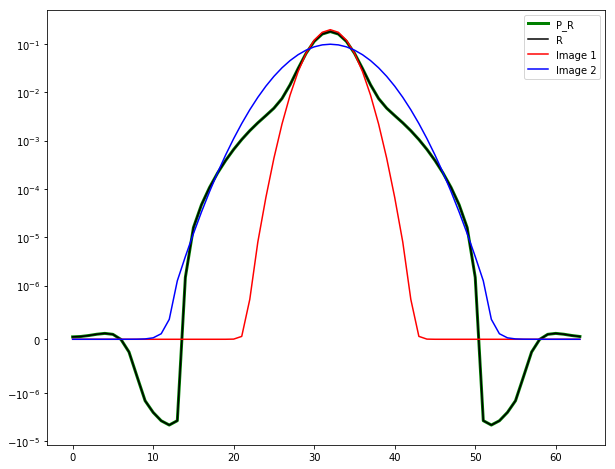

In [406]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', lw=3, label='P_R');
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='R')
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Image 1')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Image 2')
plt.yscale('symlog', linthreshy=1e-6)
plt.legend();

Investigate noise performance -- does R really have uncorrelated pixels?

In [464]:
noisy1 = np.random.normal(size=(H,W)) * sig_1
noisy2 = np.random.normal(size=(H,W)) * sig_2

In [465]:
NM1 = np.fft.rfft2(noisy1)
NM2 = np.fft.rfft2(noisy1)
N = (F1 / sig_1**2) * (P1 * NM1) + (F2 / sig_2**2) * (P2 * NM2)

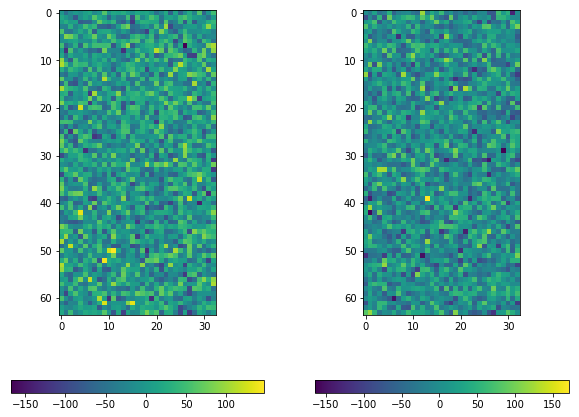

In [468]:
plt.subplot(1,2,1)
plt.imshow(NM1.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(NM1.imag)
plt.colorbar(orientation='horizontal');

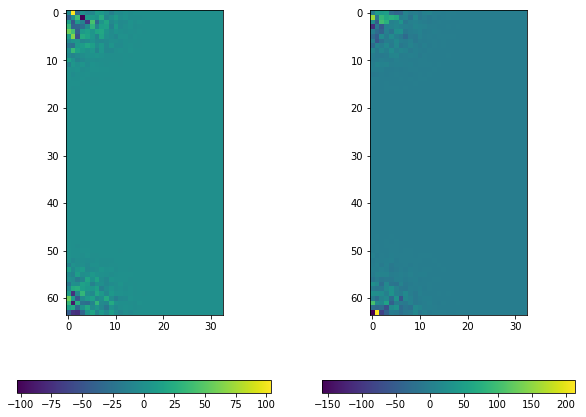

In [469]:
plt.subplot(1,2,1)
plt.imshow(N.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(N.imag)
plt.colorbar(orientation='horizontal');

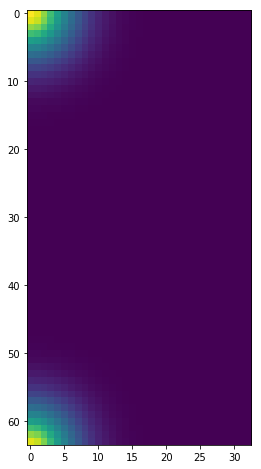

In [470]:
plt.imshow(D);

In [471]:
R = N/D
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)

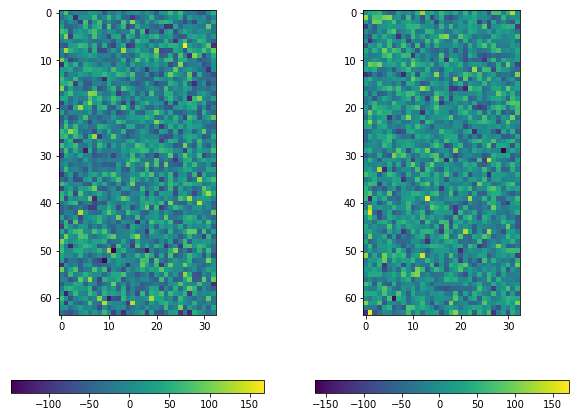

In [474]:
plt.subplot(1,2,1)
plt.imshow(R.real)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(R.imag);
plt.colorbar(orientation='horizontal');

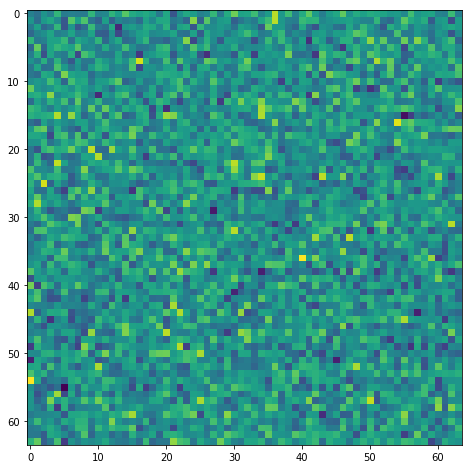

In [475]:
plt.imshow(imgR);

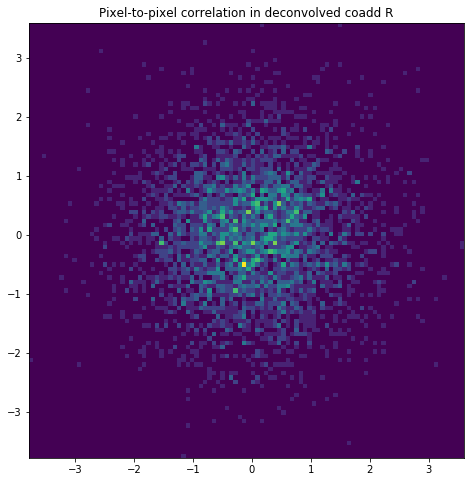

In [483]:
# Correlation between x-neighboring pixels
ha = dict(doclf=False, dohot=False, docolorbar=False, imshowargs=dict(aspect=1))
plothist(imgR[:-1,:].ravel(), imgR[1:,:].ravel(), **ha)
plt.title('Pixel-to-pixel correlation in deconvolved coadd R');

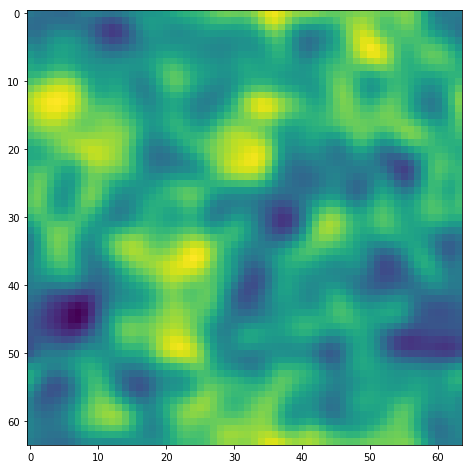

In [478]:
imgN = np.fft.irfft2(N)
imgN = np.fft.ifftshift(imgN)
plt.imshow(imgN);

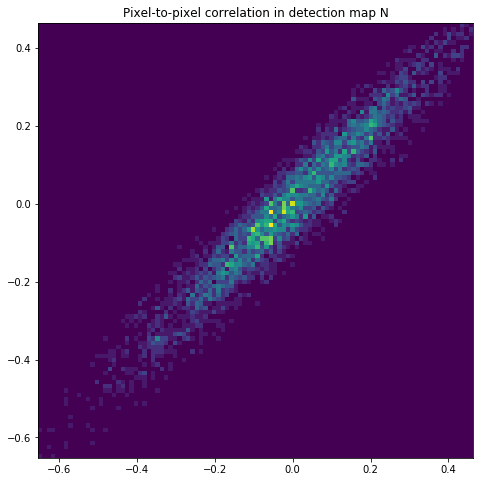

In [481]:
plothist(imgN[:-1,:].ravel(), imgN[1:,:].ravel(), **ha);
plt.title('Pixel-to-pixel correlation in detection map N');

In [487]:
# Show that deconvolving by D yields "just right" correction for correlations
Rx = N / (D**0.95)
imgRx = np.fft.irfft2(Rx)
imgRx = np.fft.ifftshift(imgRx)

Ry = N / (D**1.05)
imgRy = np.fft.irfft2(Ry)
imgRy = np.fft.ifftshift(imgRy)

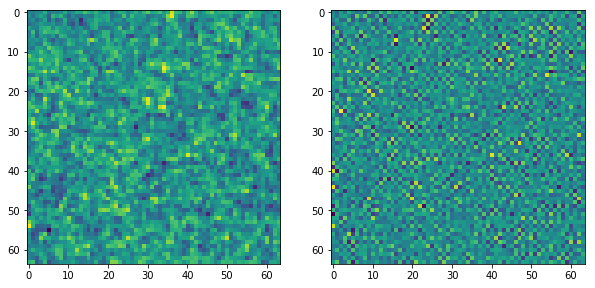

In [488]:
plt.subplot(1,2,1)
plt.imshow(imgRx);
plt.subplot(1,2,2)
plt.imshow(imgRy);

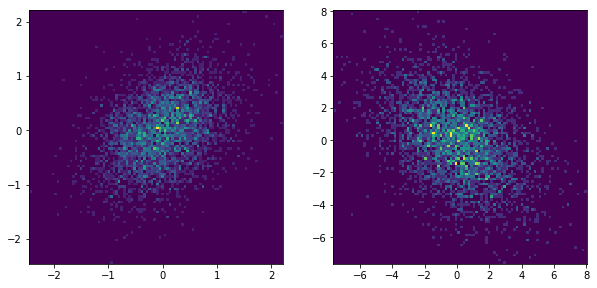

In [489]:
plt.subplot(1,2,1)
plothist(imgRx[:-1,:].ravel(), imgRx[1:,:].ravel(), **ha);
plt.subplot(1,2,2)
plothist(imgRy[:-1,:].ravel(), imgRy[1:,:].ravel(), **ha);